In [83]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sbs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from google.colab import files

In [84]:
def globalLogisticGrowth(currPops ,growthModels ,couplingCoeff, args=None):
    """
    globalLogisticGrowth is equation (1) from "Evolutionary Transitions and 
    Top-Down Causation" describing the global dynamics of the logistic growth 
    of coupled populations with independent growth models.
    Parameters
    ----------
    currPops : (N,) array_like
        The current population of the system, where each row is an individual 
        population.
    growthModels : function
        growthModels is a function where when X_i is the vector representing the
        current population then, X_i+1 = growthModels(X_i,*args). For 
        convenience see generateGrowthModels in this module for generating this
        function.
    couplingCoeff : double
        A value in the range [0,1] representing the coupling to the populations
    args: tuple, optional
        arguments to be passed to the growthModels function.
        
    Returns
    -------
    (N,) array_like
        The next population in the globalLogisticGrowth.
    """
    assert couplingCoeff>=0 and couplingCoeff<=1
    if args:
        nextPops = growthModels(currPops,*args)
    else:
        nextPops = growthModels(currPops)
    return (1-couplingCoeff)*nextPops+couplingCoeff*np.average(nextPops) 

def localLogisticGrowth(currPop, repFitCoeff, carryCap):
    """
    localLogisticGrowth is equation (2) rom "Evolutionary Transitions and 
    Top-Down Causation" describing the local dynamics of a particular population
    Parameters
    ----------
    currPop : double
        value representing the current population (x_n).
    repFitCoeff : double
        reproductive fittness (r) coefficent.
    carryCap : double
        carrying capacity (K) coefficent.
    Returns
    -------
    double 
        next generations population (x_n+1)
    """
    
    return repFitCoeff*(currPop-currPop**2/carryCap)

def generateGrowthModels(repFitCoeffs, carryCaps, repFitFun=None, carryCapFun=None):
    """
    generateGrowthModels gennerates the growthModels variable for use in the 
    globalLogisticGrowth equation. Currently it takes two list of equal length
    and creates a function to compute N growth models. When the length of the 
    input vector should be the number of local models.
    In the language of "Evolutionary Transitions and Top-Down Causation"...
    x_1,n+1    f(x_1,n,r_1,K_1)
    x_2,n+1 =  f(x_2,n,r_2,K_2)
     ...       ...
    x_N,n+1    f(x_N,n,r_N,K_N)
    
    Parameters
    ----------
    repFitCoeffs : (N,) array-like
        reproductive fittness coefficent (r_i) for the ith logistic model.
    carryCaps : (N,) array-like
       carrying capacity coeffiecent (K_i) for the ith logistic model 
    Returns
    -------
    function
        a function with a single vector argument for the current population. 
        X_n+1 = f(X_n)
    """
    if carryCapFun and repFitFun:
        return lambda pops:np.array([localLogisticGrowth(p,repFitFun(pops,r,k),carryCapFun(pops,r,k)) for p,r,k in zip(pops,repFitCoeffs,carryCaps)])
    if repFitFun:
        return lambda pops:np.array([localLogisticGrowth(p,repFitFun(pops,r,k),k) for p,r,k in zip(pops,repFitCoeffs,carryCaps)])
    if carryCapFun:
        return lambda pops:np.array([localLogisticGrowth(p,r,carryCapFun(pops,r,k)) for p,r,k in zip(pops,repFitCoeffs,carryCaps)])
    else:
        assert len(carryCaps) == len(repFitCoeffs)
        return lambda pops:np.array([localLogisticGrowth(p,r,k) for p,r,k in zip(pops,repFitCoeffs,carryCaps)])
        

def instDynamicMeanFeild(currPops,growthModels):
    """
    istDynamicMeanFeild is equation (4) from "Evolutionary Transitions and 
    Top-Down Causation". It calculates the instintanious dynamics of the mean 
    feild M_n.
    
    Parameters
    ----------
    currPops : (N,) array_like
        The current population of the system, where each row is an individual 
        population.
    growthModels : function
        growthModels is a function where when X_i is the vector representing the
        current population then, X_i+1 = growthModels(X_i,*args). For 
        convenience see generateGrowthModels in this module for generating this
        function.
    Returns
    -------
    double 
        instintanious dynamics of the mean feild M_n.
    """
    return np.average(growthModels(currPops)) 

def instMeanFeild(currPops):
    """
    instMeanFeild is equation (3) from "Evolutionary Transitions and 
    Top-Down Causation". It calculates the instintanious state of the entier 
    system.
    
    Parameters
    ----------
    currPops : (N,) array_like
        The current population of the system, where each row is an individual 
        population.
        
    Returns
    -------
    double
        nstintanious state of the entier system.
    """
    return np.average(currPops)


In [148]:
#%% FUNCTION DEFINITIONS
def generatePDFs(X,numberOfBins,binRange=None):
    if not binRange:
       binRange=(X.min(),X.max())
    bins             = np.linspace(*binRange,numberOfBins)
    binAssignments   = np.digitize(X,bins)
    prob = np.ones(shape=(X.shape[0],numberOfBins))
    for inx,popBinAssignment in enumerate(binAssignments):
        for binNumber in range(1,numberOfBins):
           prob[inx,binNumber] = np.sum(popBinAssignment==binNumber)/X.shape[1] 
    return prob
def generateJointPDF(xt,yt,NXbins,NYbins,XbinRange=None,YbinRange=None):
    if not XbinRange:
        XbinRange = (xt.min(),xt.max())
    if not YbinRange:
        YbinRange = (yt.min(),yt.max())
    xbins            = np.linspace(*XbinRange,NXbins+1)
    ybins            = np.linspace(*YbinRange,NYbins+1)
    xtBinAssignments = np.digitize(xt,xbins)
    ytBinAssignments = np.digitize(yt,ybins)
    jointPDF         = np.zeros((NXbins,NYbins))
    Xbins, Ybins     = np.meshgrid(np.arange(1,NXbins),np.arange(1,NXbins))
    for xi, yi in zip(xtBinAssignments,ytBinAssignments):
        Xbool = np.zeros(Xbins.shape);      Ybool = np.zeros(Ybins.shape); 
        Xbool[Xbins==xi]=1;                 Ybool[Ybins==yi]=1;
        jointPDF +=Xbool*Ybool
    jointPDF = jointPDF/len(xt)
    return jointPDF
    
def entropy(pdf,axis=1):
    with np.errstate(all='ignore'):
        return -1.0*np.sum(np.nan_to_num(pdf*np.log2(pdf)),axis=axis)
#%%
font = {'family' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)


#%% Parameters
N_generations = 100
N_populations = 4
carryingCapacity = 100

R = np.array([1.7,1.7,3.7,3.7])
K = np.ones((N_populations,))*carryingCapacity
X = np.zeros(shape=(N_populations,N_generations))
X2 = np.zeros(shape=(N_populations,N_generations))

# Initial Populations
#X[:,0] = np.array([0.55,0.56,0.57,0.58,0.55,0.56,0.57,0.58])
X[:,0] = np.array([0.55,0.56,0.55,0.56])
X2[:,0] = np.array([0.57,0.58,0.57,0.58])
print(range(N_generations-1))

#%% popigate the generations
for gen in range(N_generations-1):
  X[:,gen+1] = localLogisticGrowth(X[:,gen],R,K)

for gen in range(N_generations-1):
  X2[:,gen+1] = localLogisticGrowth(X2[:,gen],R,K)


#%% Usefull calculations
# Calculate the diff between the two pop to determine divergence    
Xdiff = np.array([np.abs(X[0,:]-X[1,:]),np.abs(X[2,:]-X[3,:])])
N = 10 # This by observation of looking at resulting plots

# bin discritization for use with JIDT tool
numberOfBins    = 10
binRange        = (0.0,carryingCapacity)
bins            = np.linspace(*binRange,numberOfBins)
binAssignments  = np.digitize(X,bins)

# Sanity check
# Calc pobability dist.
fullTimeSeries_pdfs  = generatePDFs(X,numberOfBins,binRange)
firstNtimesteps_pdfs = generatePDFs(X[:,:N],numberOfBins,binRange)
lastNtimesteps_pdfs  = generatePDFs(X[:,-N:],numberOfBins,binRange)
print("Shannon entropyies:")
print(entropy(fullTimeSeries_pdfs))
HofFirstN  = entropy(firstNtimesteps_pdfs)
HofLastN   = entropy(lastNtimesteps_pdfs)

#%% Save Data to text for calculations
np.savetxt('fullTimeSeries.txt',binAssignments.T,fmt='%d')    
np.savetxt('firstNtimesteps.txt',binAssignments[:,:N].T,fmt='%d')    
np.savetxt('lastNtimesteps.txt',binAssignments[:,-N:].T,fmt='%d')    



range(0, 99)
Shannon entropyies:
[0.60609065 0.60609065 2.75157182 2.7760784 ]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


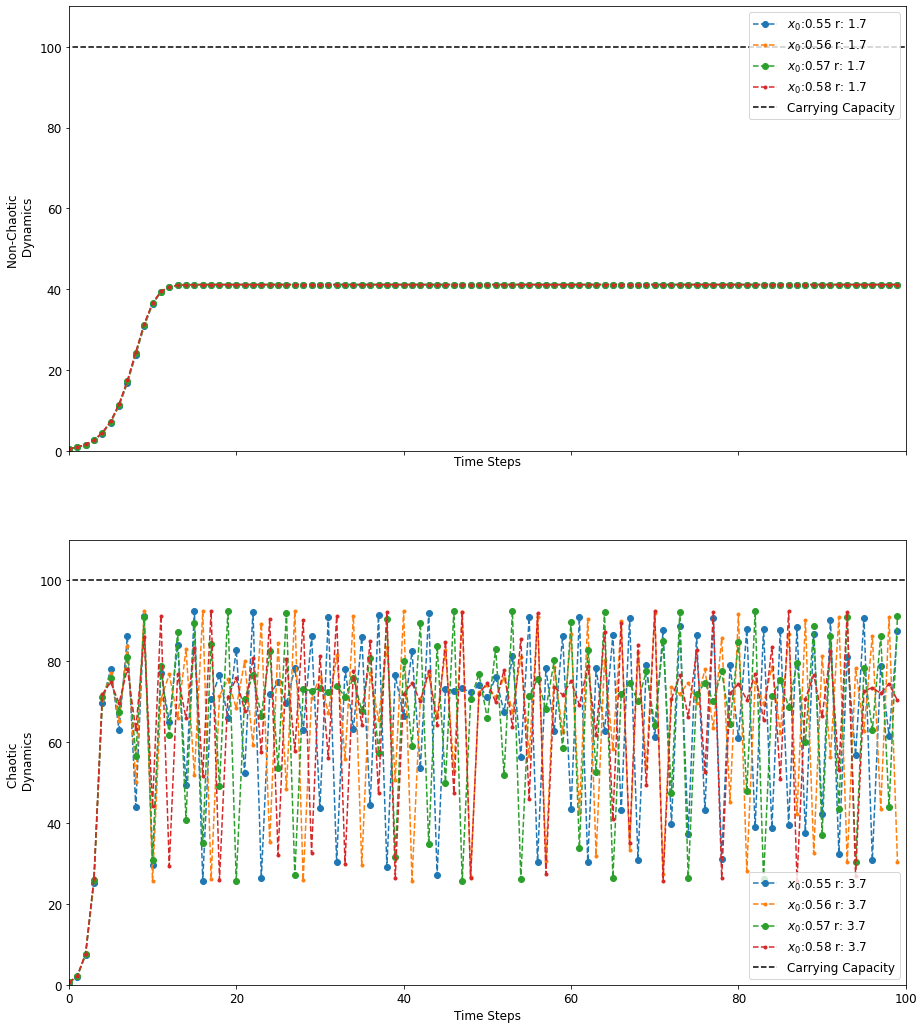

In [86]:
#%% time series plots  

fig, axarr = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(3,2))
fig.set_figwidth(15)
fig.set_figheight(18)
axarr[0].plot(X[0,:],'--o',markersize=6, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X[0,0],R[0]))
axarr[0].plot(X[1,:],'--o',markersize=3, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X[1,0],R[1]))
axarr[0].plot(X2[0,:],'--o',markersize=6, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X2[0,0],R[0]))
axarr[0].plot(X2[1,:],'--o',markersize=3, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X2[1,0],R[1]))
axarr[1].plot(X[2,:],'--o',markersize=6, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X[2,0],R[2]))
axarr[1].plot(X[3,:],'--o',markersize=3, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X[3,0],R[3]))
axarr[1].plot(X2[2,:],'--o',markersize=6, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X2[2,0],R[2]))
axarr[1].plot(X2[3,:],'--o',markersize=3, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X2[3,0],R[3]))


axarr[0].hlines(carryingCapacity,-10,N_generations+10,linestyles="dashed", label="Carrying Capacity")
axarr[1].hlines(carryingCapacity,-10,N_generations+10,linestyles="dashed", label="Carrying Capacity")

axarr[0].set_xlabel('Time Steps', fontsize=12)
axarr[1].set_xlabel('Time Steps', fontsize=12)
axarr[0].set_ylabel('Non-Chaotic \n Dynamics', fontsize=12)
axarr[1].set_ylabel('Chaotic \n Dynamics', fontsize=12)
axarr[1].set_xlim(0,N_generations)
axarr[0].set_xlim(0,N_generations)
axarr[1].set_ylim(0,carryingCapacity+10)
axarr[0].set_ylim(0,carryingCapacity+10)
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


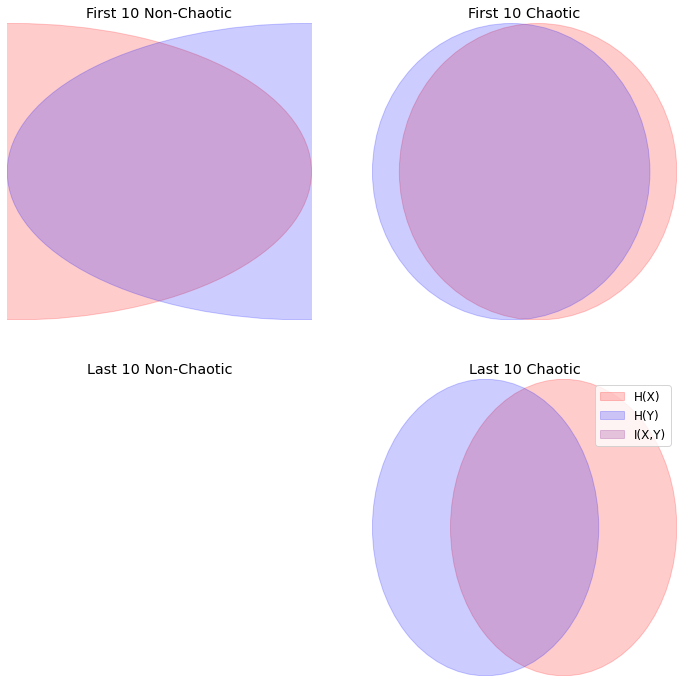

In [87]:
#%% Make Venn diagram
# Inputs       First N time steps          Last  N time steps
#             Non-Chaotic   Chaoti        Non-Chaotic  Chaotic          
Xentropies = [HofFirstN[0], HofFirstN[2], HofLastN[0], HofLastN[2]]  
Yentropies = [HofFirstN[1], HofFirstN[3], HofLastN[1], HofLastN[3]]  
mutualInfo = [2.0419,       2.3899,      0.0,         1.4716]
titles=['First {} Non-Chaotic','First {} Chaotic',
        'Last {} Non-Chaotic', 'Last {} Chaotic']
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(8,8)) 
fig.set_figwidth(12)
fig.set_figheight(12)

for ax,hx,hy,mi,ti in zip(np.ravel(axarr),Xentropies,Yentropies,mutualInfo,titles):
    
    venX = Circle((hx/2-mi/2,0),hx/2, 
                  alpha =0.2, color ='red', label='H(X)')
    venY = Circle((-hy/2+mi/2,0),hy/2, 
                  alpha =0.2, color ='blue', label='H(Y)')
    mutI = Circle((0,0),1,alpha =0.2, color='purple',label='I(X,Y)')
    ax.add_artist(venX);    ax.add_artist(venY); 
    ax.set_title(ti.format(N))
    
    
    plt.legend(handles = [venX,venY,mutI])
    ax.set_xlim(-hy+mi/2,hx-mi/2)
    ax.set_ylim(max(hy,hx)/2,max(hy,hx)/-2)
    ax.axis('off')

In [88]:
eps_vals = [0.225, 0.25, 0.275]

In [89]:
# The model calculated at population i generation n+1
def calc_x_inp1(eps, i, n, K, N):
    x[i, n] = (1-eps)*calc_f(x[i, n-1], K) + eps*calc_m_n(N, n-1, K)


# Local dynamics of a population i at generation n, the discrete logistic map
def calc_f(x_val, K):
    return get_r()*x_val*(1-(x_val/K))


# The instantaneous mean field
def calc_M_n():
    return np.average(x, axis=0)


# The dynamics of the instantaneous mean field
def calc_m_n(N, n, K):
    return np.average(calc_f(x[:, n], K))


# Sampling of r in the chaotic regime, random.uniform provides an independent
# uniform distribution between 3.9 and 4.0
def get_r():
    return np.random.uniform(3.9, 4.0)


# Runs the simulation for the specified parameters, sets the initial generation
def run_sim(eps, x_0, K, N, generations):
    x[:, 0] = x_0
    for n in range(1, generations):
        for i in range(N):
            calc_x_inp1(eps, i, n, K, N)


# Makes the scatter plot
def plot(M, index):
    colors = ['m', 'r', 'b', 'y', 'c', 'g', 'k', 'k']
    x_vals = M[:-1]
    y_vals = M[1:]
    if index == 6:
        mark = '*'
        s = 15
    else:
        mark = 'o'
        s = 1
    plt.scatter(x_vals, y_vals, c=colors[index], marker=mark, s=s)


# Sets plotting parameters and adds a logistic map
def plotspecs():
    xmin = 40
    xmax = 80
    plt.title('Map for Varying Values of the Global Coupling Strength')
    plt.xlabel('$M_n$')
    plt.ylabel('$M_{n+1}$')
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    plt.rcParams.update({'font.size': 9})
    plt.plot([xmin, xmax], [xmin, xmax], 'k-')
    x = np.linspace(0, 1)
    plt.plot(x*100, get_r()*x*(1-x)*100, 'g', LineWidth=3)
    plt.show()
    plt.savefig("abc.png", dpi=300)
    files.download("abc.png") 
    # sts = "logmap_iter" + str(iteration) + "_" + str(x_0) + ".png"
    # plt.savefig(sts)


# Used for part 3 to generate 3 samples of populations from the metapopulation
# Saves each file with the first column as the instantaneous mean field and
# the second, third, and fourth as the population data for all generations,
# Also stores all values rounded to the nearest integer to use the discrete
# value transfer entropy tool.
def storedata(xtrans, M, N, gens, index, metapop):
    sample = np.random.choice(xtrans.shape[1], 3, replace=False)
    print(sample)
    chosenpops = xtrans[:, sample]
    dataarray = np.zeros((gens, 4))
    dataarray[:, 0] = M
    dataarray[:, 1:] = chosenpops
    # print(np.round(dataarray))
    np.savetxt("TEdata/MX_" + str(index) + '_' + str(metapop) + ".csv",
               np.round(dataarray), fmt='%d', delimiter=',')


# Sets parameters.  If part 2 (pic=True) runs the simulation for all epsilon
# and plots the figure.  If part 3 runs the simulation and stores the 3
# sampled populations
def main(x_0, eps_vals, pic=False):
    K = 100
    N = 1000
    metapops = 10  # For part 3
    generations = 1000  # For part 3
    global x
    if pic:
        plt.clf()
        metapops = 1  # For part 2
        generations = 5000  # For part 2
    for index in range(0, 7):  # range(len(eps_vals)):
        eps = eps_vals[index]
        print(eps)
        for metapop in range(metapops):
            x = np.zeros((N, generations))
            run_sim(eps, x_0, K, N, generations)
            M = calc_M_n()
            if not pic:
                storedata(np.transpose(x), M, N, generations, index, metapop)
            if pic:
                plot(M, index)
        print("Finished epsilon = ", eps)
    if pic:
        plotspecs()


# If part 2 sets epsilon values to match Walker.  If part 3 sets epsilon values
# to be between 0 and 1 at 0.025 increments
if __name__ == "__main__":
    eps_vals_pic = [0, 0.075, 0.1, 0.2, 0.225, 0.25, 0.275, 0.3, 0.4]
    #eps_vals = [0.225, 0.25, 0.275]
    x0 = 1
    main(x0, eps_vals_pic, pic=True)


0


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [90]:
from google.colab import drive
drive.mount('/content/drive')

new_df = pd.read_csv(f'/content/drive/MyDrive/Proj1_CS523/us-states.csv', delimiter=',', header=0) # read in the CSV file
new_df.dataframeName = f"COVID Numbers for US States"  # Name of the dataframe
new_df.dropna(inplace=True)                               # Remove NA Elements

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
new_df.head()

,date,geoid,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53,Washington,1,0.14,0.0,0,0.0,0.0
1,2020-01-22,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
2,2020-01-23,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
3,2020-01-24,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
4,2020-01-24,USA-17,Illinois,1,0.14,0.0,0,0.0,0.0


In [100]:
fl_df = new_df[new_df.geoid == 'USA-12']
fl_df = fl_df[['geoid','state','date','cases_avg']]

In [124]:
fl_df.head()

,geoid,state,date,cases_avg
250,USA-12,Florida,2020-03-01,0.29
265,USA-12,Florida,2020-03-02,0.29
281,USA-12,Florida,2020-03-03,0.43
298,USA-12,Florida,2020-03-04,0.43
318,USA-12,Florida,2020-03-05,0.57


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


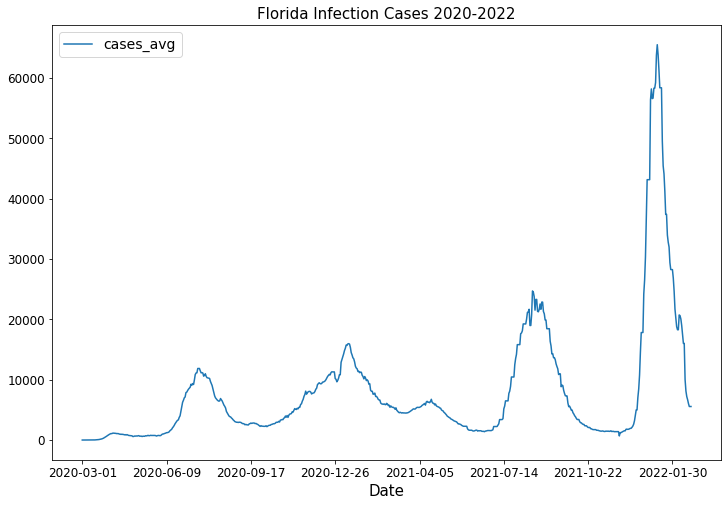

In [94]:
flplot = fl_df.plot(x = 'date', y = 'cases_avg', kind = 'line', figsize=(12, 8), legend=True, fontsize = 12)
flplot.legend(fontsize=14)
flplot.set_title('Florida Infection Cases 2020-2022', fontdict={'fontsize':15})
flplot.set_xlabel('Date', fontdict={'fontsize':15})
fig = flplot.get_figure()

In [125]:
ca_df = new_df[new_df.geoid == 'USA-06']
ca_df = ca_df[['geoid','state','date','cases_avg']]
ca_df = ca_df.iloc[36:,:]
ca_df.head()

,geoid,state,date,cases_avg
251,USA-06,California,2020-03-01,2.67
266,USA-06,California,2020-03-02,3.86
282,USA-06,California,2020-03-03,4.25
299,USA-06,California,2020-03-04,4.14
320,USA-06,California,2020-03-05,5.13


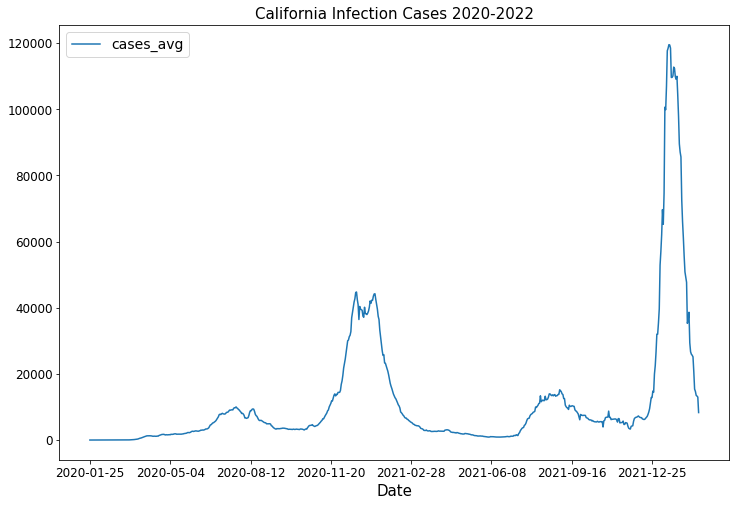

In [96]:
caplot = ca_df.plot(x = 'date', y = 'cases_avg', kind = 'line', figsize=(12, 8), legend=True, fontsize=12)
caplot.legend(fontsize=14)
caplot.set_title('California Infection Cases 2020-2022', fontdict={'fontsize':15})
caplot.set_xlabel('Date', fontdict={'fontsize':15})
fig = caplot.get_figure()
#fig.savefig("abc.png", dpi = 300)
#files.download("abc.png") 

In [157]:
#%% FUNCTION DEFINITIONS
def generatePDFs(X,numberOfBins,binRange=None):
    if not binRange:
       binRange=(X.min(),X.max())
    bins             = np.linspace(*binRange,numberOfBins)
    binAssignments   = np.digitize(X,bins)
    prob = np.ones(shape=(X.shape[0],numberOfBins))
    for inx,popBinAssignment in enumerate(binAssignments):
        for binNumber in range(1,numberOfBins):
           prob[inx,binNumber] = np.sum(popBinAssignment==binNumber)/X.shape[1] 
    return prob
def generateJointPDF(xt,yt,NXbins,NYbins,XbinRange=None,YbinRange=None):
    if not XbinRange:
        XbinRange = (xt.min(),xt.max())
    if not YbinRange:
        YbinRange = (yt.min(),yt.max())
    xbins            = np.linspace(*XbinRange,NXbins+1)
    ybins            = np.linspace(*YbinRange,NYbins+1)
    xtBinAssignments = np.digitize(xt,xbins)
    ytBinAssignments = np.digitize(yt,ybins)
    jointPDF         = np.zeros((NXbins,NYbins))
    Xbins, Ybins     = np.meshgrid(np.arange(1,NXbins),np.arange(1,NXbins))
    for xi, yi in zip(xtBinAssignments,ytBinAssignments):
        Xbool = np.zeros(Xbins.shape);      Ybool = np.zeros(Ybins.shape); 
        Xbool[Xbins==xi]=1;                 Ybool[Ybins==yi]=1;
        jointPDF +=Xbool*Ybool
    jointPDF = jointPDF/len(xt)
    return jointPDF
    
def entropy(pdf,axis=1):
    with np.errstate(all='ignore'):
        return -1.0*np.sum(np.nan_to_num(pdf*np.log2(pdf)),axis=axis)
#%%
font = {'family' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)


#%% Parameters
N_generations = 20
N_populations = 4
carryingCapacity = 20

R = np.array([1.7,1.7,3.7,3.7])
K = np.ones((N_populations,))*carryingCapacity
X1 = np.zeros(shape=(N_populations,N_generations))
X2 = np.zeros(shape=(N_populations,N_generations))

# Initial Populations
#X[:,0] = np.array([0.55,0.56,0.57,0.58,0.55,0.56,0.57,0.58])
#X[:,0] = np.array([0.55,0.56,0.55,0.56])
#print(range(N_generations-1))

# Create a new list of COVID-19 data
fl_list = fl_df['cases_avg'].tolist()
ca_list = ca_df['cases_avg'].tolist()

X_arr = [fl_list, ca_list, fl_list, ca_list]
X = np.array(X_arr)

#%% Usefull calculations
# Calculate the diff between the two pop to determine divergence    
Xdiff = np.array([np.abs(X[0,:]-X[1,:]), np.abs(X[2,:]-X[3,:])])
N = 15 # This by observation of looking at resulting plots

# bin discritization for use with JIDT tool
numberOfBins    = 10
binRange        = (0.0,carryingCapacity)
bins            = np.linspace(*binRange,numberOfBins)
binAssignments  = np.digitize(X,bins)

# Sanity check
# Calc pobability dist.
fullTimeSeries_pdfs  = generatePDFs(X,numberOfBins,binRange)
firstNtimesteps_pdfs = generatePDFs(X[:,:N],numberOfBins,binRange)
lastNtimesteps_pdfs  = generatePDFs(X[:,-N:],numberOfBins,binRange)
print("Shannon entropyies:")
print(entropy(fullTimeSeries_pdfs))
HofFirstN  = entropy(firstNtimesteps_pdfs)
HofLastN   = entropy(lastNtimesteps_pdfs)

#%% Save Data to text for calculations
np.savetxt('fullTimeSeries.txt',binAssignments.T,fmt='%d')    
np.savetxt('firstNtimesteps.txt',binAssignments[:,:N].T,fmt='%d')    
np.savetxt('lastNtimesteps.txt',binAssignments[:,-N:].T,fmt='%d')    



Shannon entropyies:
[0.16519544 0.11753599 0.16519544 0.11753599]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

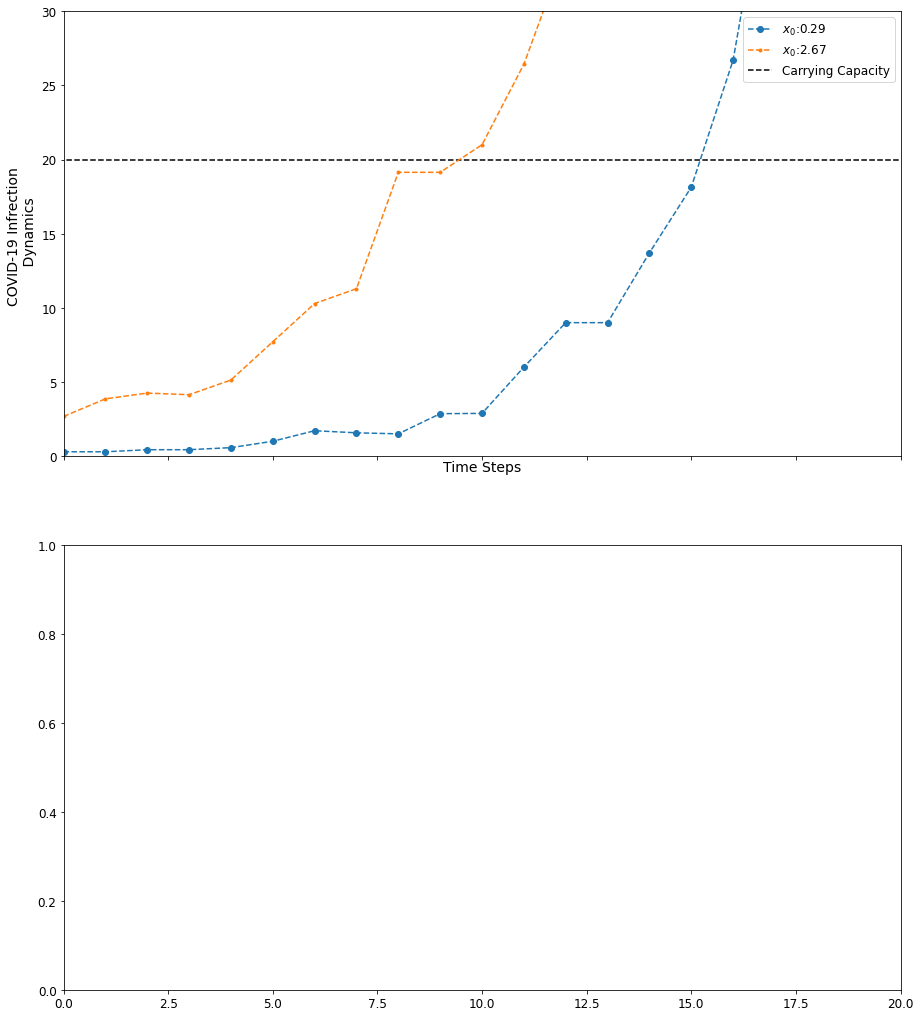

In [166]:
#%% time series plots  

fig, axarr = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(3,2))
fig.set_figwidth(15)
fig.set_figheight(18)
axarr[0].plot(X[0,:],'--o',markersize=6, label='$x_0$:{:3.2f}'.format(X[0,0],R[0]))
axarr[0].plot(X[1,:],'--o',markersize=3, label='$x_0$:{:3.2f}'.format(X[1,0],R[1]))
#axarr[1].plot(X[2,:],'--o',markersize=6, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X[2,0],R[2]))
#axarr[1].plot(X[3,:],'--o',markersize=3, label='$x_0$:{:3.2f} r: {:2.1f}'.format(X[3,0],R[3]))


axarr[0].hlines(carryingCapacity,-10,N_generations+10,linestyles="dashed", label="Carrying Capacity")
#axarr[1].hlines(carryingCapacity,-10,N_generations+10,linestyles="dashed", label="Carrying Capacity")

axarr[0].set_xlabel('Time Steps', fontsize=14)
#axarr[1].set_xlabel('Time Steps', fontsize=12)
axarr[0].set_ylabel('COVID-19 Infrection \n Dynamics', fontsize=14)
#axarr[1].set_ylabel('Chaotic \n Dynamics', fontsize=12)
axarr[0].set_xlim(0,N_generations)
#axarr[1].set_xlim(0,N_generations)
axarr[0].set_ylim(0,carryingCapacity+10)
#axarr[1].set_ylim(0,carryingCapacity+10)
axarr[0].legend(fontsize=12)
#axarr[1].legend(fontsize=12)
    
fig.savefig("abc.png", dpi = 300)
files.download("abc.png") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

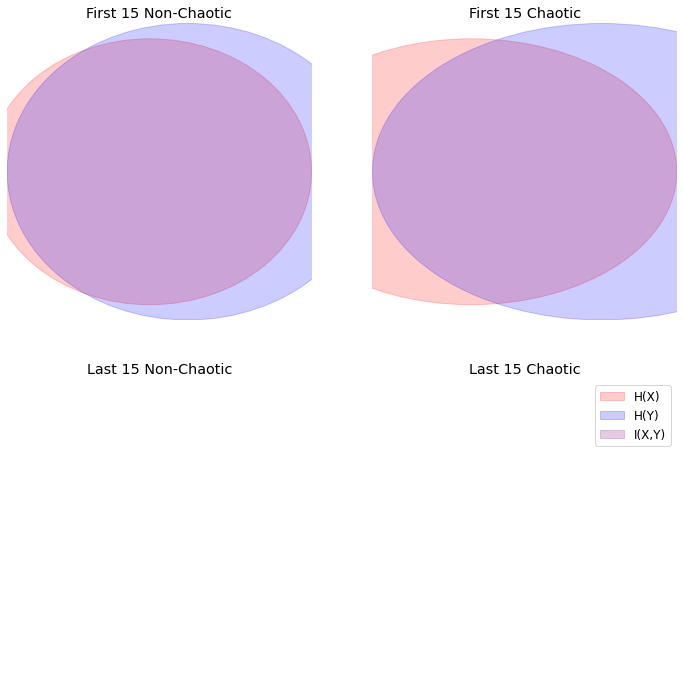

In [160]:
#%% Make Venn diagram
# Inputs       First N time steps          Last  N time steps
#             Non-Chaotic   Chaoti        Non-Chaotic  Chaotic          
Xentropies = [HofFirstN[0], HofFirstN[2], HofLastN[0], HofLastN[2]]  
Yentropies = [HofFirstN[1], HofFirstN[3], HofLastN[1], HofLastN[3]]  
mutualInfo = [2.0419,       2.3899,      0.0,         1.4716]
titles=['First {} Non-Chaotic','First {} Chaotic',
        'Last {} Non-Chaotic', 'Last {} Chaotic']
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(8,8)) 
fig.set_figwidth(12)
fig.set_figheight(12)

for ax,hx,hy,mi,ti in zip(np.ravel(axarr),Xentropies,Yentropies,mutualInfo,titles):
    
    venX = Circle((hx/2-mi/2,0),hx/2, 
                  alpha =0.2, color ='red', label='H(X)')
    venY = Circle((-hy/2+mi/2,0),hy/2, 
                  alpha =0.2, color ='blue', label='H(Y)')
    mutI = Circle((0,0),1,alpha =0.2, color='purple',label='I(X,Y)')
    ax.add_artist(venX);    ax.add_artist(venY); 
    ax.set_title(ti.format(N))
    
    
    plt.legend(handles = [venX,venY,mutI])
    ax.set_xlim(-hy+mi/2,hx-mi/2)
    ax.set_ylim(max(hy,hx)/2,max(hy,hx)/-2)
    ax.axis('off')
